In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
!pip install -q git+https://github.com/tensorflow/docs 
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile


print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.9.2
Hub version:  0.12.0
GPU is available


In [2]:
 #load data
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [3]:
print((df[df['target']==1]).value_counts())

qid                   question_text                                                                                                                                                                                                                                       target
0000e91571b60c2fb487  Has the United States become the largest dictatorship in the world?                                                                                                                                                                                 1         1
aadc6fb5444ddbb025e0  Can you easily prove that the world is 2017 years old?                                                                                                                                                                                              1         1
aae065c499ac1114d2d6  If proxy state “Turkey” was never created by England and France, would the majority of the population have maintained their original ethnicity (Greek

In [4]:
print((df[df['target']==0]).value_counts())

qid                   question_text                                                                                                                                   target
00002165364db923c7e6  How did Quebec nationalists see their province as a nation in the 1960s?                                                                        0         1
aa9654583d742b98d648  If you were in Seattle for one night and could eat anywhere, where would it be, and what would you eat?                                         0         1
aa9647bfee3972a7d1a7  Would any sculptor be interested in creating a tree of ideas in a public park?                                                                  0         1
aa96389b07bd4df08b7a  Is it good to take Elitmus exam being a metallurgical engineer?                                                                                 0         1
aa961dda27dc98f048ec  How do you disassemble a Makita LXRM03 radio?                                                

In [5]:
df.shape

(1306122, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [7]:
df.describe()

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


Text(0.5, 1.0, 'Target Distribution')

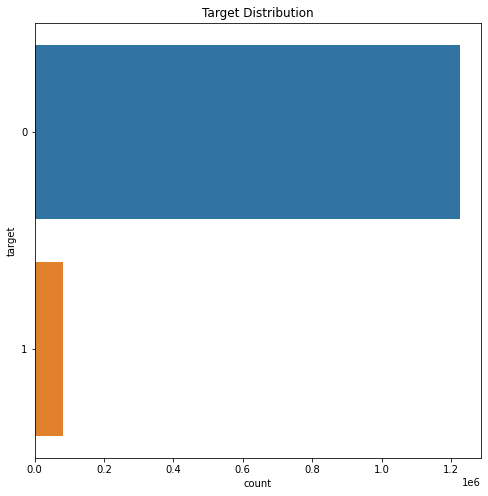

In [8]:
#plot classes
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.countplot(y = df['target'], data = df)
plt.title('Target Distribution')

In [9]:
import nltk
nltk.download()  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [10]:
def without_hue(data,feature,ax):
    
    total=float(len(data))
    bars_plot=ax.patches
    
    for bars in bars_plot:
        percentage = '{:.1f}%'.format(100 * bars.get_height()/total)
        x = bars.get_x() + bars.get_width()/2.0
        y = bars.get_height()
        ax.text(x, y,(percentage,bars.get_height()),ha='center',fontweight='bold',fontsize=10)

In [11]:
def length(text):
    length = len(text.split(" "))
    return(length)
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [12]:
# df.to_excel('/content/drive/MyDrive/Colab Notebooks/cleaned_text.xlsx')
df_train=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/cleaned_text.xlsx')

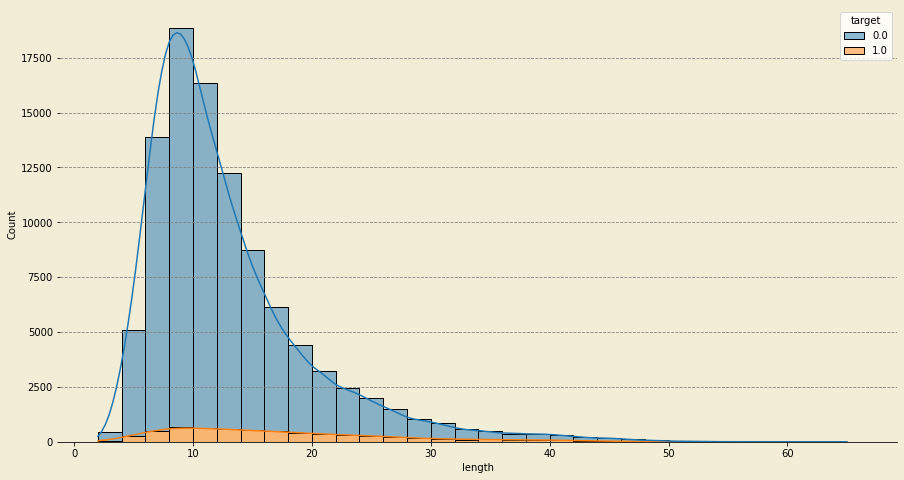

In [13]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_facecolor("#F2EDD7FF")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(linestyle="--",axis='y',color='gray')

a=sns.histplot(data=df_train,x='length',hue='target',kde=True,binwidth=2,multiple='stack')

In [14]:
under_df =df[df['target']==1]
under_df.columns

Index(['qid', 'question_text', 'target'], dtype='object')

In [15]:
df.iloc[1,:]

qid                                           000032939017120e6e44
question_text    Do you have an adopted dog, how would you enco...
target                                                           0
Name: 1, dtype: object

In [22]:
under_df.shape

(162093, 3)

In [23]:
count=i=0
for i in range(0,200000):
  if df['target'][i]==0 and count<80810:
    under_df=under_df.append(df.iloc[i,:])
    count=count+1
  elif count>80810:
    break

In [24]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def remove_stopwords(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation)).split(" ")
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(i) for i in text if i not in set(stopwords.words('english'))]
    text = " ".join(text)
    return(text)
under_df['cleaned_text'] = under_df['question_text'].apply(remove_stopwords)
under_df['length'] = under_df['question_text'].apply(length)

In [25]:
under_df.head()

,qid,question_text,target,cleaned_text,length
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,united state become largest dictatorship world,11
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1,baby sweeter parent dark skin baby light skin ...,15
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1,black support school choice mandatory sentenci...,15
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1,gay boy love cousin boy sexy dont know hot wan...,34
115,000537213b01fd77b58a,Which races have the smallest penis?,1,race smallest penis,6


In [26]:
under_df.shape

(242903, 5)

Text(0.5, 1.0, 'Target Distribution')

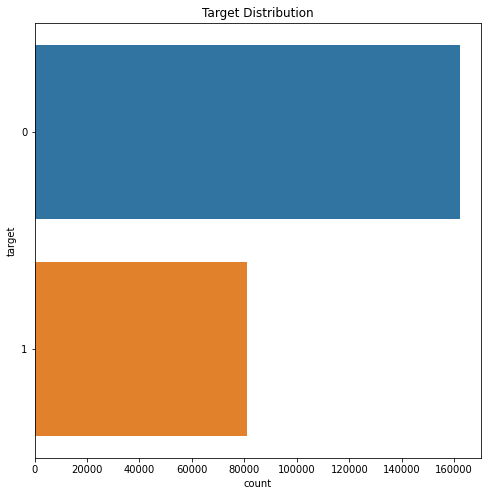

In [27]:
#plot classes
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.countplot(y = under_df['target'], data = under_df)
plt.title('Target Distribution')

In [28]:
import nltk
from nltk.probability import FreqDist
import string

#download stopwords
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

#create insincere dataframe
insincere_df = df[df["target"]==1]

#create a frequency distribution to see which words are used the most
words = list(insincere_df['question_text'].values)
stopwords = stopwords_list
split_words = []

In [29]:
for word in words:
    lo_w = []
    list_of_words = str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []

for wordlist in split_words:
    allwords += wordlist
    
#get 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
mostcommon

[('Why', 32673),
 ('I', 11236),
 ('people', 10869),
 ('Is', 8396),
 ('How', 7510),
 ('What', 6106),
 ('Do', 5656),
 ('like', 5638),
 ('Trump', 4701),
 ('women', 4639),
 ('Are', 4611),
 ('think', 3758),
 ('If', 3688),
 ('many', 3471),
 ('get', 3152),
 ('would', 3123),
 ('men', 3047),
 ('Indian', 2966),
 ('white', 2914),
 ('Muslims', 2802),
 ('Quora', 2541),
 ('Americans', 2474),
 ('want', 2332),
 ('black', 2331),
 ('hate', 2145),
 ('Indians', 2104),
 ('girls', 2067),
 ('India', 2038),
 ('sex', 2030),
 ('make', 1924),
 ('Chinese', 1833),
 ('US', 1748),
 ('Should', 1717),
 ('liberals', 1707),
 ('Can', 1685),
 ('even', 1683),
 ('Does', 1666),
 ('Muslim', 1618),
 ('American', 1614),
 ('feel', 1568),
 ('much', 1528),
 ('one', 1518),
 ('know', 1507),
 ('believe', 1486),
 ('When', 1479),
 ('Donald', 1478),
 ('really', 1449),
 ('say', 1373),
 ('still', 1350),
 ('world', 1324),
 ('true', 1305),
 ('good', 1247),
 ('people?', 1239),
 ('always', 1209),
 ('Will', 1190),
 ("can't", 1174),
 ('ever', 1

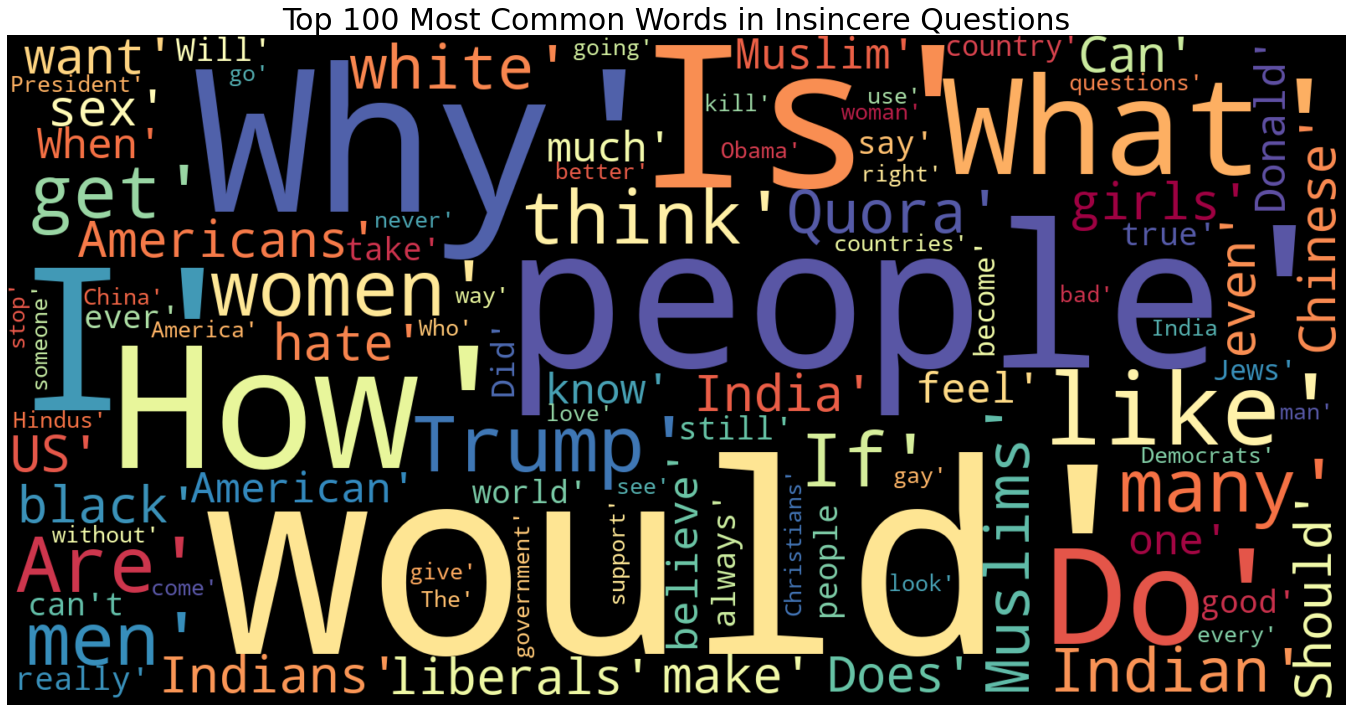

In [30]:
#plot frequency distributions
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in Insincere Questions', fontsize = 30)
plt.tight_layout()

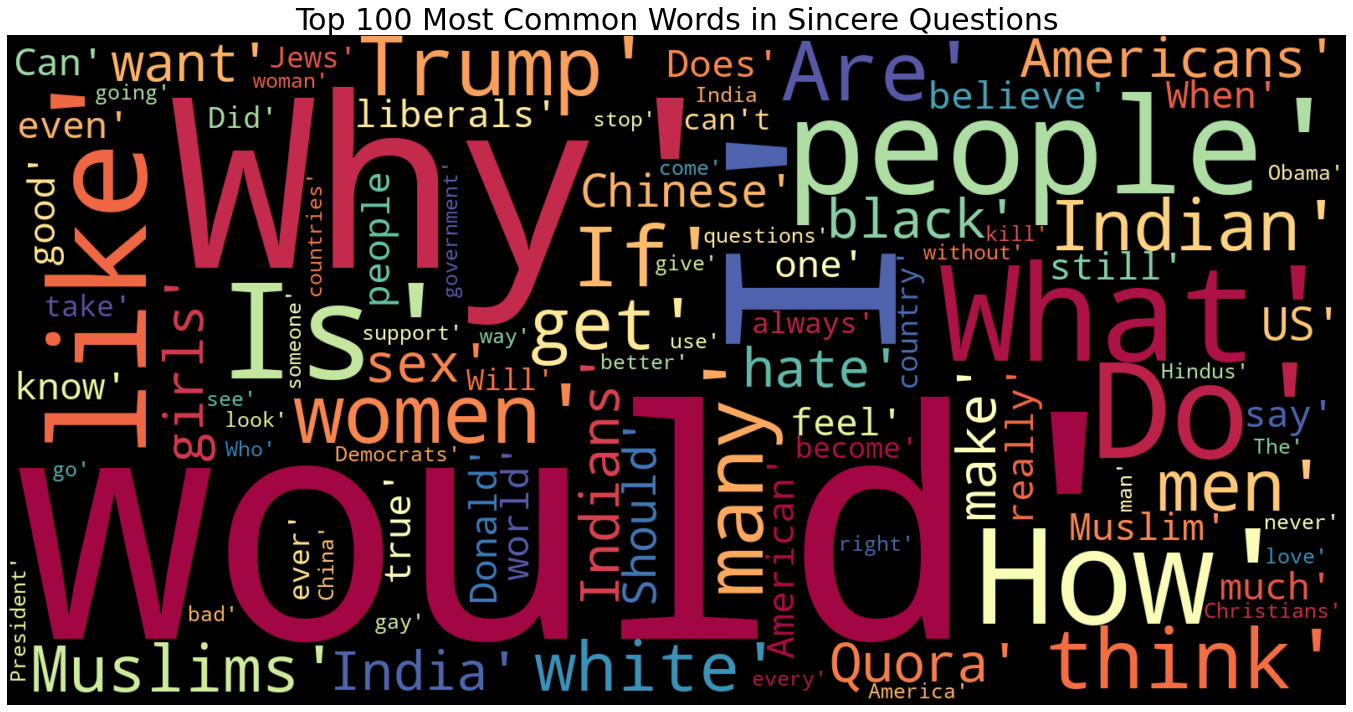

In [31]:
#plot frequency distributions
wordcloud = WordCloud(width = 1600, height = 800, 
                      background_color = 'black', 
                      colormap = 'Spectral', 
                      stopwords = stopwords_list).generate(str(mostcommon))

fig = plt.figure(figsize = (20, 10), facecolor = 'white')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 100 Most Common Words in Sincere Questions', fontsize = 30)
plt.tight_layout()

In [32]:
from wordcloud import WordCloud
df_sin = df.loc[df['target']==0]
df_insin = df.loc[df['target']==1]
df_sin_para = " ".join([word for word in df_sin['question_text']])
df_insin_para = " ".join([word for word in df_insin['question_text']])

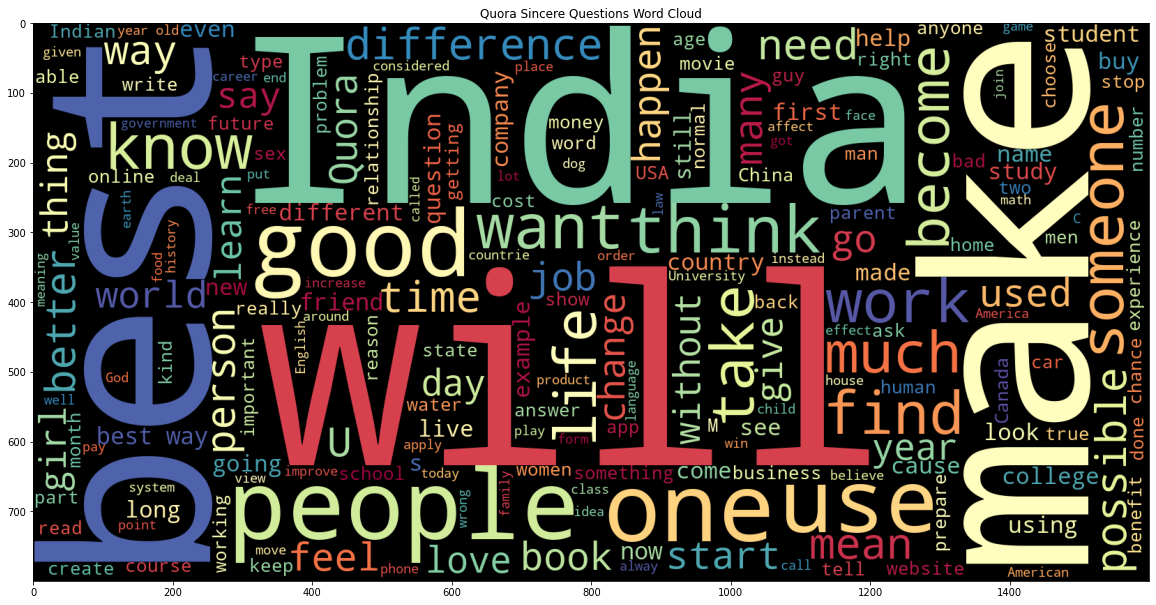

In [33]:
wordcloud=WordCloud(width=1600, height = 800,background_color = 'black', colormap = 'Spectral').generate(df_sin_para)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Quora Sincere Questions Word Cloud")
plt.show()

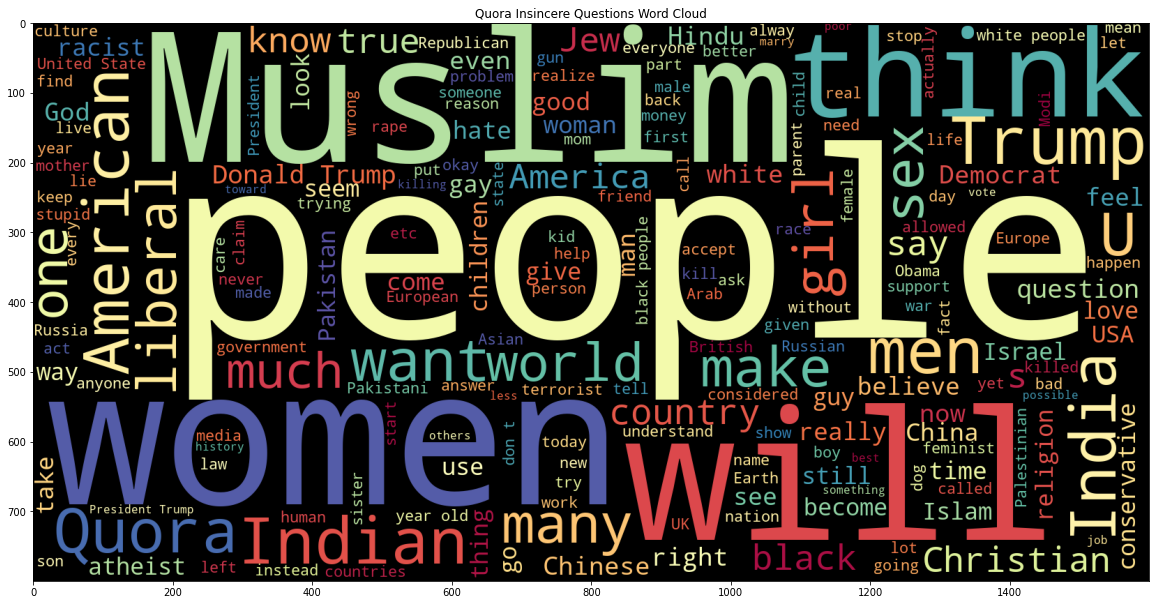

In [34]:
wordcloud=WordCloud(width=1600, height = 800,background_color = 'black', colormap = 'Spectral').generate(df_insin_para)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Quora Insincere Questions Word Cloud")
plt.show()

#Model Implementation

In [35]:
#look at classes
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distribution')

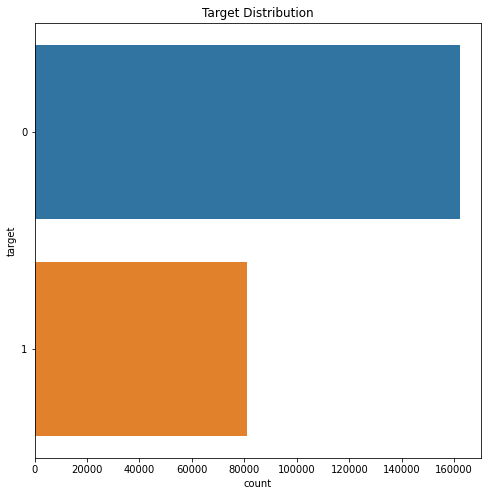

In [36]:
#plot classes
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.countplot(y = under_df['target'], data = under_df)
plt.title('Target Distribution')

In [37]:
#train test split
#create a training df and store the rest in remaining
# from fast_ml.model_development import train_valid_test_split
# train_df, test_df, valid_df = train_valid_test_split(under_df, method='sorted', sort_by_col='s/no',
                                                          # train_size=0.7, test_size=0.15,valid_size=0.15)
train_df, remaining = train_test_split(under_df, 
                                       random_state=42, 
                                       train_size=0.1, 
                                       stratify=under_df.target.values)

#create validation df with the remaining and ignore the rest
valid_df, _ = train_test_split(remaining,                        #use the remaining
                               random_state=42, 
                               train_size=0.01, 
                               stratify=remaining.target.values) #stratify with the remaining

#check shape
train_df.shape, valid_df.shape

((24290, 5), (2186, 5))

In [38]:
#see sample texts
train_df['question_text'].head(15).values

array(['What are the advantages of television advertising?',
       'Is there any app that converts torrents to direct link?',
       'Do supporters of Donald Trump know that Trump lies about almost everything that he says? Do people really not care that their political candidate lies?',
       'What is the syllabus for mathematics in commerce?',
       'How do foreigners view Chinese gay-themed novels?',
       'How is the PhB (especially in Science) course in ANU?',
       'Why does the boy child never get favours?',
       "Is GPU mining dangerous for other computers on my network? Does it add any security issues for mine, or other's computers on my network?",
       'Is there a plug adapter that can be used in all countries?',
       'What is the safest option in India to make online payments?',
       'What does your old "burnt" hookah tobacco look and feel like?',
       'Threadworms are moving from my anus to my vagina, and I pick them up alive with my fingers and store them in 

In [39]:
#see sample labels
train_df['target'].head(15).values

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [40]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [41]:
def train_and_evaluate_model(module_url,         #module url
                             embed_size, 
                             name,               #module name
                             trainable=True):

  #import module as a keras layer
  hub_layer = hub.KerasLayer(module_url,                  
                             input_shape=[],     #arbitrary length string
                             output_shape=[embed_size], 
                             dtype=tf.string, 
                             trainable=trainable)

  #build model architect
  model = tf.keras.models.Sequential([hub_layer, #will generate fixed length vector
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')]) #output

  #compile
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
  
  #summary
  model.summary()

  #fit
  history = model.fit(train_df['question_text'], train_df['target'],
                    epochs=100,
                    batch_size=900,
                    validation_data=(valid_df['question_text'], valid_df['target']),
                    callbacks=[tfdocs.modeling.EpochDots(), #keep the screen tidy by not outputing loss & acc
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                               tf.keras.callbacks.TensorBoard(logdir/name)],
                    verbose=0)
  
  return history

In [42]:
histories =history_= {}

In [43]:
module_url = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

history_['gnews-swivel-20dim'] = train_and_evaluate_model(module_url,
                                                           embed_size=20,
                                                           name='gnews-swivel-20dim')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6407,  loss:0.6549,  val_accuracy:0.7063,  val_loss:0.6108,  
..................................................................

In [44]:
histories['gnews-swivel-20dim']=history_['gnews-swivel-20dim']

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
from IPython.core import history
module_url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1'
history_={}

history_['nnlm-en-dim50'] = train_and_evaluate_model(module_url,
                                  embed_size=50,
                                  name='nnlm-en-dim50')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 256)               13056     
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 48,220,169
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6307,  loss:0.6740,  val_accuracy:0.6661,  val_loss:0.6565,  
...................

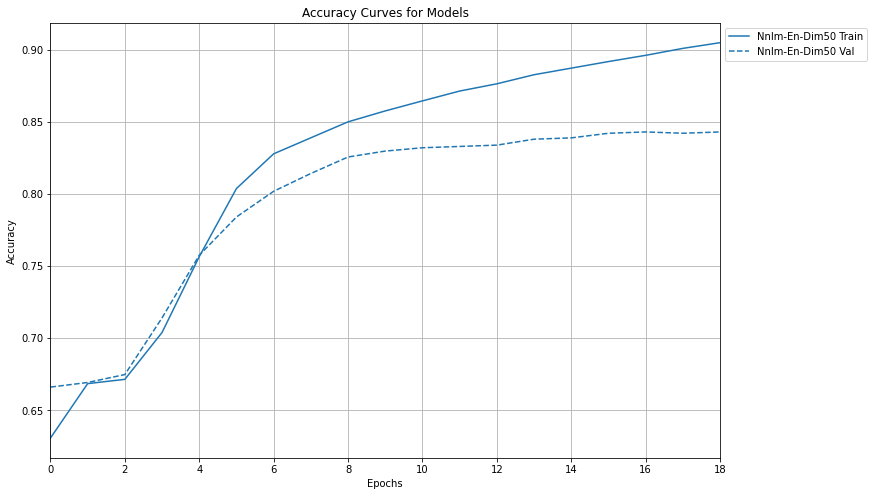

In [ ]:
histories['nnlm-en-dim50']=history_['nnlm-en-dim50']
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

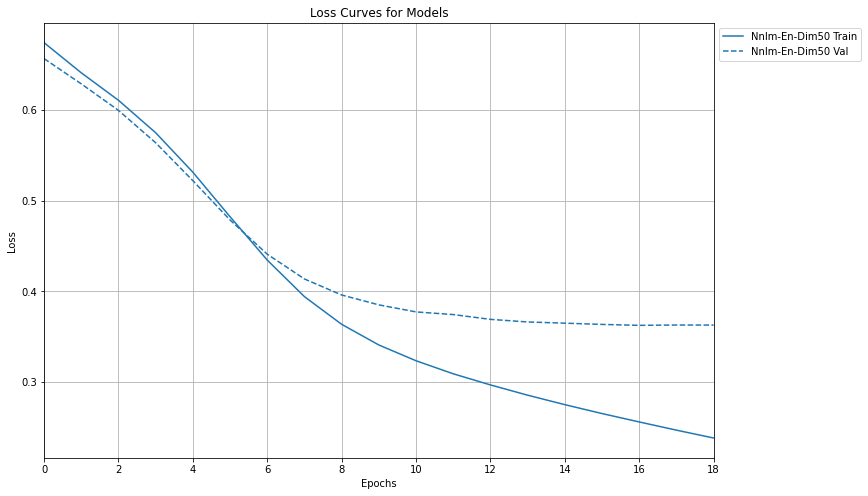

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
module_url = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'
history_={}

history_['gnews-swivel-20dim-finetuned'] = train_and_evaluate_model(module_url,
                                                           embed_size=20,
                                                           name='gnews-swivel-20dim-finetuned',
                                                           trainable=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_6 (Dense)             (None, 256)               5376      
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6439,  loss:0.6714,  val_accuracy:0.6688,  val_loss:0.6308,  
............................................................................

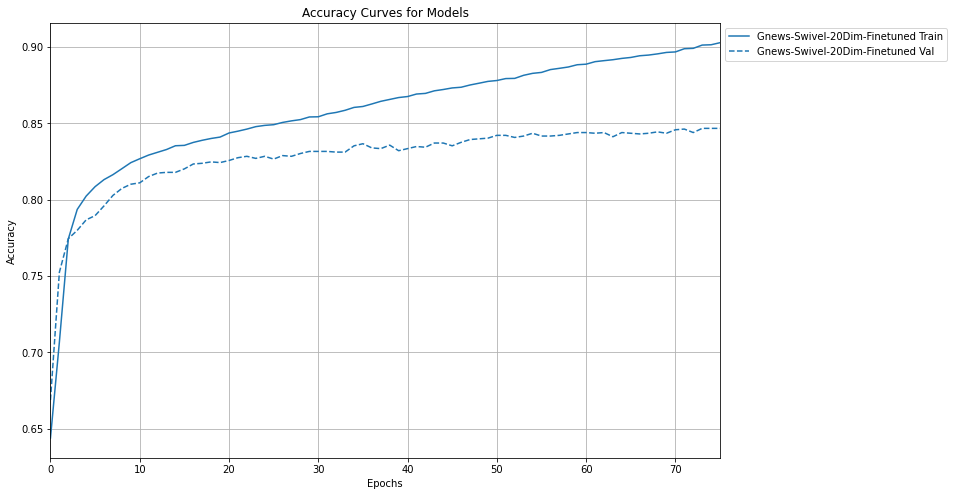

In [ ]:
histories['gnews-swivel-20dim-finetuned']=history_['gnews-swivel-20dim-finetuned']
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

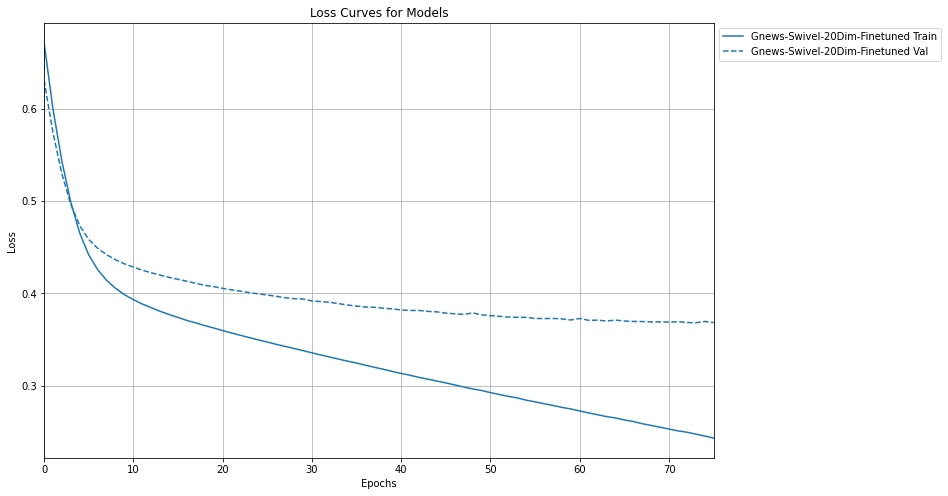

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs") 
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
module_url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1'
history_={}
history_['nnlm-en-dim50-finetuned'] = train_and_evaluate_model(module_url,
                                                                embed_size=50,
                                                                name='nnlm-en-dim50-finetuned',
                                                                trainable=True)
histories['nnlm-en-dim50-finetuned']=history_['nnlm-en-dim50-finetuned']

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_9 (Dense)             (None, 256)               13056     
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 48,220,169
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6275,  loss:0.6805,  val_accuracy:0.6683,  val_loss:0.6645,  
....................

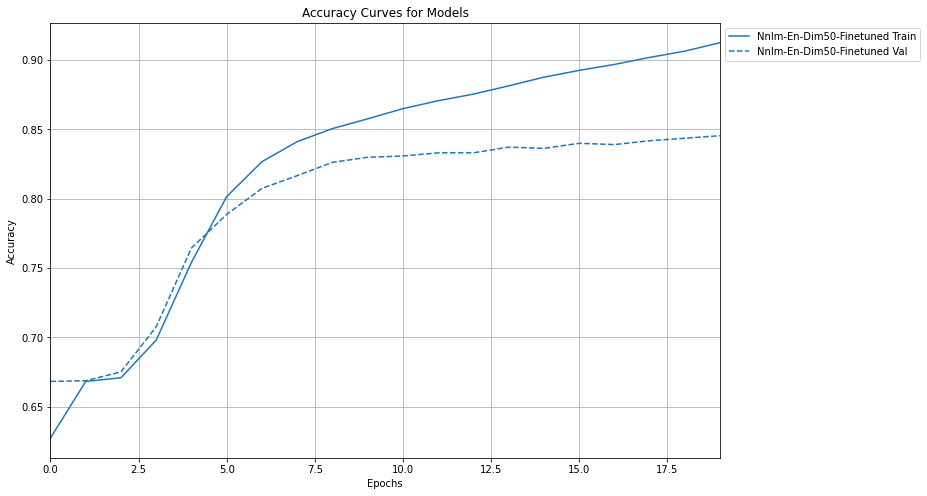

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

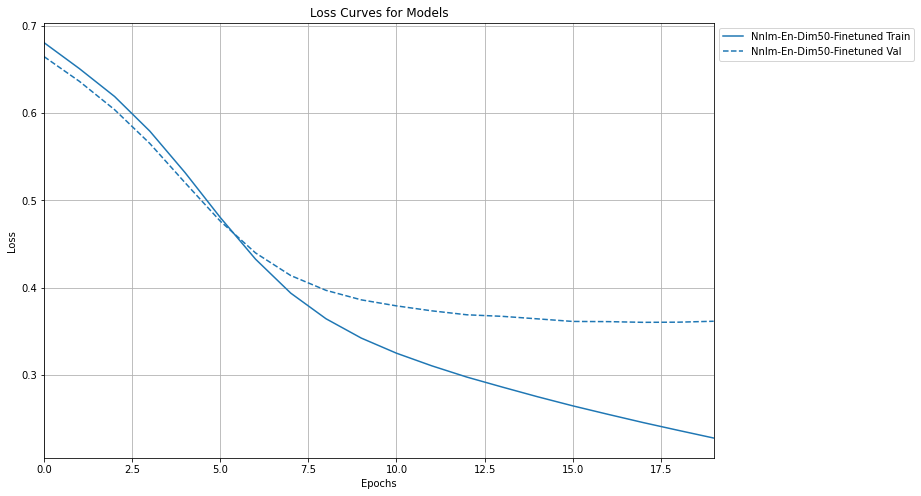

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
module_url = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
history_={}
history_['nnlm-en-dim128-finetuned'] = train_and_evaluate_model(module_url,
                                                                 embed_size=128,
                                                                 name='nnlm-en-dim128-finetuned',
                                                                 trainable=True)
histories['nnlm-en-dim128-finetuned']=history_['nnlm-en-dim128-finetuned']

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_12 (Dense)            (None, 256)               33024     
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 124,692,225
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6624,  loss:0.6708,  val_accuracy:0.6702,  val_loss:0.6529,  
.............

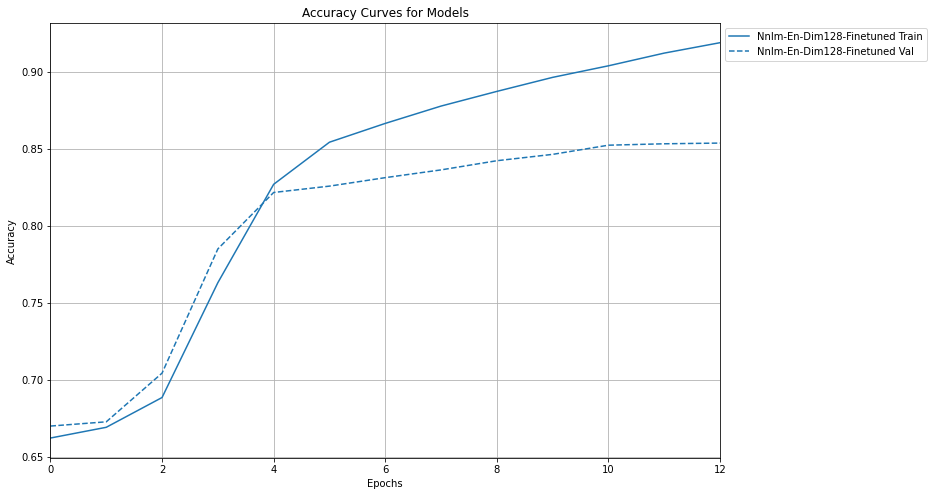

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

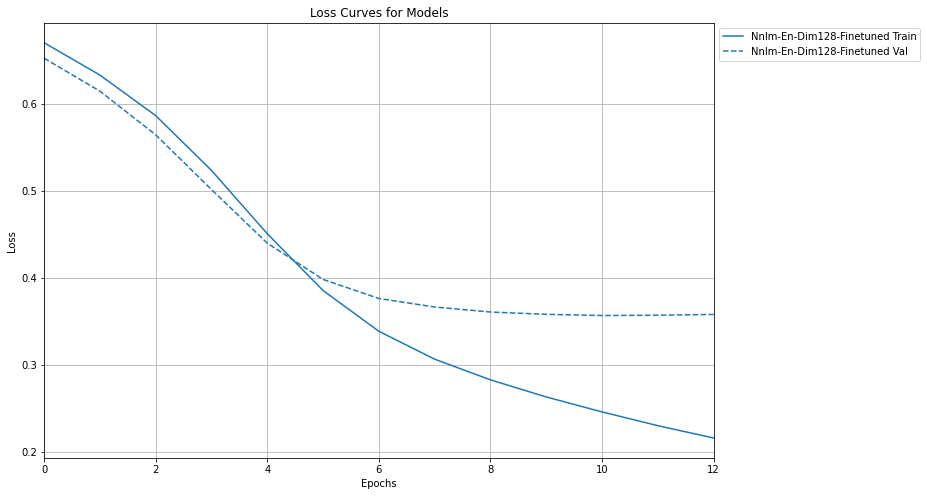

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
history_={}
history_['universal-sentence-encoder'] = train_and_evaluate_model(module_url,
                                                                   embed_size=256,
                                                                   name='universal-sentence-encoder')
                                           
histories['universal-sentence-encoder']=history_['universal-sentence-encoder']

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 256,945,665
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.6296,  loss:0.6723,  val_accuracy:0.6770,  val_loss:0.6376,  
............

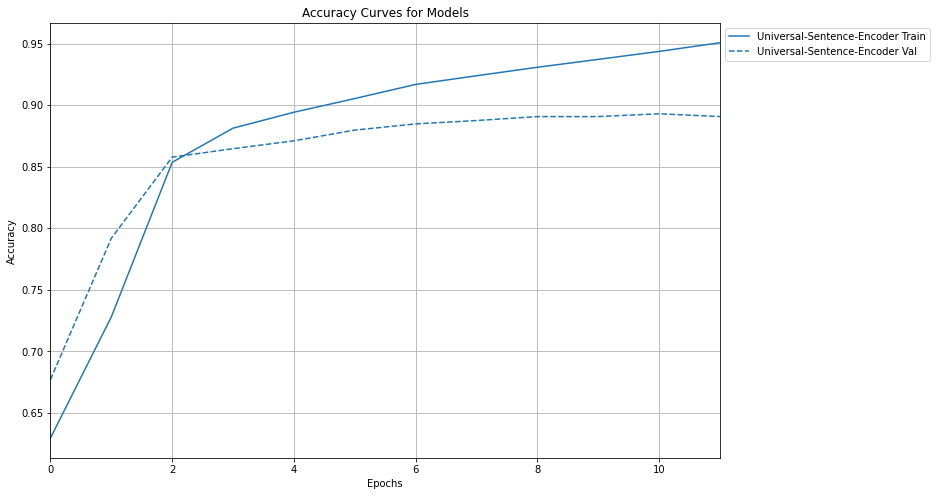

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

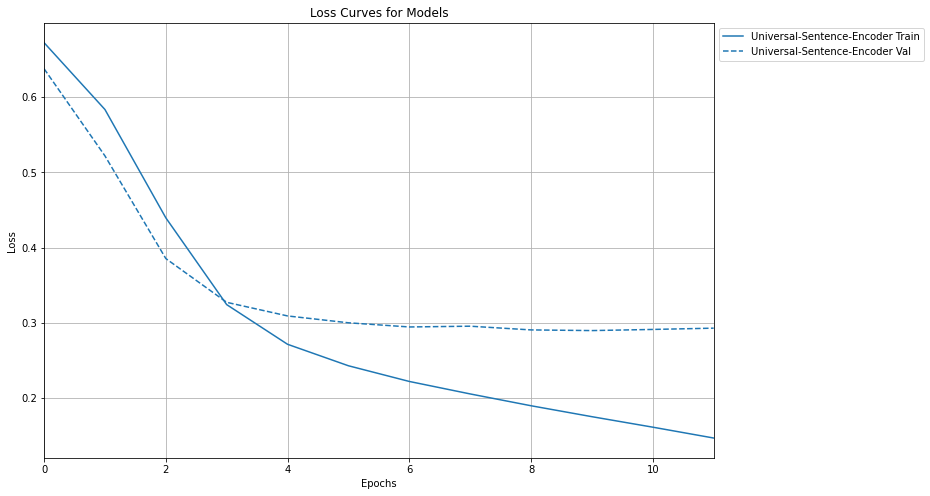

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
history_={}
history_['universal-sentence-encoder-large'] = train_and_evaluate_model(module_url,
                                                                   embed_size=512,
                                                                   name='universal-sentence-encoder-large',
                                                                   trainable=False)

In [ ]:
histories['universal-sentence-encoder-large']=history_['universal-sentence-encoder-large']

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(history_)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Universal Sentence Encoder Large")
plt.show()

#Results Comparision

print(histories)

In [ ]:
from tensorflow_docs.plots import HistoryPlotter
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

In [ ]:
#Number of echoes ran to get the best accuracy individualy
print(len(histories['gnews-swivel-20dim'].history['val_accuracy']))
print(len(histories['gnews-swivel-20dim-finetuned'].history['val_accuracy']))
print(len(histories['nnlm-en-dim50'].history['val_accuracy']))
print(len(histories['nnlm-en-dim50-finetuned'].history['val_accuracy']))
print(len(histories['nnlm-en-dim128-finetuned'].history['val_accuracy']))
print(len(histories['universal-sentence-encoder'].history['val_accuracy']))
print(len(histories['universal-sentence-encoder-large'].history['val_accuracy']))

In [ ]:
#Validation_accuracy
print(max(histories['gnews-swivel-20dim'].history['val_accuracy']))
print(max(histories['gnews-swivel-20dim-finetuned'].history['val_accuracy']))
print(max(histories['nnlm-en-dim50'].history['val_accuracy']))
print(max(histories['nnlm-en-dim50-finetuned'].history['val_accuracy']))
print(max(histories['nnlm-en-dim128-finetuned'].history['val_accuracy']))
print(max(histories['universal-sentence-encoder'].history['val_accuracy']))
print(max(histories['universal-sentence-encoder-large'].history['val_accuracy']))

In [ ]:
#Validation_loss
print(min(histories['gnews-swivel-20dim'].history['val_loss']))
print(min(histories['gnews-swivel-20dim-finetuned'].history['val_loss']))
print(min(histories['nnlm-en-dim50'].history['val_loss']))
print(min(histories['nnlm-en-dim50-finetuned'].history['val_loss']))
print(min(histories['nnlm-en-dim128-finetuned'].history['val_loss']))
print(min(histories['universal-sentence-encoder'].history['val_loss']))
print(min(histories['universal-sentence-encoder-large'].history['val_loss']))

In [ ]:
#Training_accuracy
print(max(histories['gnews-swivel-20dim'].history['accuracy']))
print(max(histories['gnews-swivel-20dim-finetuned'].history['accuracy']))
print(max(histories['nnlm-en-dim50'].history['accuracy']))
print(max(histories['nnlm-en-dim50-finetuned'].history['accuracy']))
print(max(histories['nnlm-en-dim128-finetuned'].history['accuracy']))
print(max(histories['universal-sentence-encoder'].history['accuracy']))
print(max(histories['universal-sentence-encoder-large'].history['accuracy']))

In [ ]:
#Train_loss
print(min(histories['gnews-swivel-20dim'].history['loss']))
print(min(histories['gnews-swivel-20dim-finetuned'].history['loss']))
print(min(histories['nnlm-en-dim50'].history['loss']))
print(min(histories['nnlm-en-dim50-finetuned'].history['loss']))
print(min(histories['nnlm-en-dim128-finetuned'].history['loss']))
print(min(histories['universal-sentence-encoder'].history['loss']))
print(min(histories['universal-sentence-encoder-large'].history['loss']))

In [ ]:
print(1225312/1306122)